# Grover's search algorithm using quantum singular value transformation 1

This is the very concrete, somewhat unrealistic but pedagogically clearer implementation which relies on applying polynomial to the singular value encoded in the block encoding unitary.

The work is based on paper [A Grand Unification of Quantum Algorithms](https://arxiv.org/abs/2105.02859).

After all, the implementation failed because obtaining the concrete block encoding seems to be hard.

1. Create block encoding of the single singular value $a = \langle m | \varphi_0 \rangle$ (??)
2. Apply the polynomial approximation of step function to the singular value (OK)
3. Create the corresponding operator using `qml.QubitUnitary` and measure in computational basis 

In [1]:
import numpy as np
import pennylane as qml

system_qubits = 3
ancilla_qubits = 0
n_qubits = system_qubits + ancilla_qubits
marked_elem = 5
delta = 0.1
epsilon = delta/2

In [2]:
def grover_oracle(n_qubits, marked_elem):
    oracle = np.eye(2**n_qubits)
    oracle[marked_elem][marked_elem] = -1
    return oracle

1. Use QSVT to construct the operator $(P^{\Theta}_{\sigma/2, \Delta})^{\text{SV}}(V)$, where $V = I$ block encodes $a = 1/\sqrt{N}$ in its $|m\rangle \langle\psi_0|$.
2. Apply $(P^{\Theta}_{\sigma/2, \Delta})^{\text{SV}}(V)$ to the uniform superposition. With high probability, $|m \rangle$ remains in the register and can be determined by measuring in the computational basis.

Degree:  10
<class 'numpy.ndarray'>


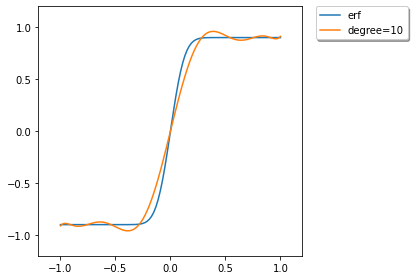

In [11]:
from scipy.special import erf
from scipy.optimize import fmin
import matplotlib.pyplot as plt
import numpy as np

from numpy.polynomial.chebyshev import chebinterpolate, chebval, chebtrim

k = 7
c = 0 #1/np.sqrt(2**n_qubits)
mod_erf = lambda x : (1 - 2*epsilon)*erf(k*(x - c))
x = np.linspace(-1.0, 1.0, num = 100)
degree = np.ceil(np.sqrt(2**n_qubits)*np.log2(1/delta)).astype(int)
print("Degree: ", degree)

plt.plot(x, mod_erf(x), label="erf")
P = chebinterpolate(mod_erf, degree)
#P = chebtrim(P, tol=1e-10)
print(type(P))
plt.plot(x, chebval(x, P), label=f"degree={degree}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, shadow=True)
plt.tight_layout()
plt.axis([-1.2, 1.2, -1.2, 1.2])
plt.show()

#### Projectors

In [4]:
N = 2**n_qubits
a = 1 #1/np.sqrt(N)

#uniform_superposition = np.zeros(2**n_qubits)
#uniform_superposition[marked_elem] = 1/np.sqrt(2**n_qubits)
uniform_superposition_orthogonal = np.ones(2**n_qubits)/np.sqrt(2**n_qubits)
#uniform_superposition_orthogonal[marked_elem] = 0

marked_element = np.zeros(2**n_qubits)
marked_element[marked_elem] = 1
marked_orthogonal = np.ones(2**n_qubits)
marked_orthogonal[marked_elem] = 0

uniform_superposition = np.ones(2**n_qubits)/np.sqrt(2**n_qubits)

Pi = np.outer(marked_element, marked_element)
Pi_prime = np.outer(uniform_superposition, uniform_superposition)
V = np.identity(2**n_qubits)
#V[marked_elem][marked_elem] = 1/np.sqrt(2**n_qubits)
#print(V)
#print()
#block_encoding = Pi*Pi_prime
#print(np.transpose(uniform_superposition)*Pi*uniform_superposition)

# Pi*V*|phi_0> = a|m>
#print(np.matmul(Pi*V, np.transpose(uniform_superposition)))

# Pi*V*Pi = a|m><phi_0|
#B = np.outer(marked_element, uniform_superposition)
#C = Pi*V*Pi_prime
#print(C)
#block = np.matmul(uniform_superposition, Pi, uniform_superposition)
block = mod_erf(np.matmul(Pi, Pi_prime))

In [5]:
ancilla = [0]
system = list(range(1, n_qubits + 1))

projector = Pi_prime
first = qml.matrix(qml.PauliX(wires = ancilla) @ qml.QubitUnitary(projector, wires = system))
second2 = qml.QubitUnitary(np.identity(len(projector)) - projector, wires = system)
second = qml.matrix(qml.Identity(wires = ancilla) @ second2)
controlled_projector_not =  np.array(first) + np.array(second)
#print(controlled_projector_not)

def block_encoding():
    #qml.Hadamard(wires = ancilla)

    
    qml.QubitUnitary(controlled_projector_not, wires = system + ancilla)
    #print(qml.is_unitary(qml.QubitUnitary(controlled_projector_not, wires = system + ancilla)))

    #qml.Hadamard(wires = ancilla)



In [6]:
block_encoding()

In [7]:
dev = qml.device('default.qubit', wires=system + ancilla)

@qml.qnode(dev)
def example_circuit():
    #block_encoding()
    qml.BlockEncode(block, wires=system + ancilla)
    return qml.probs(system)

In [8]:
example_circuit()

tensor([0.00000000e+00, 0.00000000e+00, 3.13776003e-02, 0.00000000e+00,
        9.66924820e-01, 5.65859763e-04, 5.65859763e-04, 5.65859763e-04], requires_grad=True)

In [9]:
dev = qml.device('default.qubit', wires=[0,1,2,3])

M = qml.math.T(qml.math.conj(np.outer(marked_element, uniform_superposition))) + np.outer(marked_element, uniform_superposition)
print(M)

@qml.qnode(dev)
def example_circuit2():
    qml.BlockEncode(block, wires=[0,1,2,3])
    return qml.probs(qml.Hermitian(M, wires=[0,1,2]))
print(qml.math.T(qml.math.conj(np.outer(marked_element, uniform_superposition))))


example_circuit2()

[[0.         0.         0.         0.         0.         0.35355339
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.35355339
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.35355339
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.35355339
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.35355339
  0.         0.        ]
 [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.70710678
  0.35355339 0.35355339]
 [0.         0.         0.         0.         0.         0.35355339
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.35355339
  0.         0.        ]]
[[0.         0.         0.         0.         0.         0.35355339
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.35355339
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.35355339
 

WireError: Did not find some of the wires (Hermitian(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.35355339, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.35355339, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.35355339, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.35355339, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.35355339, 0.        , 0.        ],
       [0.35355339, 0.35355339, 0.35355339, 0.35355339, 0.35355339,
        0.70710678, 0.35355339, 0.35355339],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.35355339, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.35355339, 0.        , 0.        ]]), wires=[0, 1, 2]),) on device with wires (0, 1, 2, 3).